## Теоретическая часть


1. Ответьте на вопросы:  
В чем принципиальное отличие гибридных рекомендательных систем от коллаборативной филтьтрации?  
Приведите 2-3 примера задач, в которых необходимо использовать гибридные системы  




**Ответ:**

Гибридные сисетмы помимо информации о взаимодействии пользователя с продуктом используют информацию о пользователях и продуктах.

Гибридные товары необходимо использовать при появлении новых пользователей или новых продуктов, когда нет информации о взаимодействии пользователей с продуктом.

2.  Прочитайте статью про поиск на hh.ru https://habr.com/ru/company/hh/blog/347276/
Нам интересна именно рекомендательная система, раздел "Производительность системы" можно пропустить
Какие основные отличия предложенной системы от тех подходов, которые мы разбирали на семинарах? Какие проблемы могут возникнуть при выводе такой модели в продакшен?

**Ответ:**

Использовалось последовательное применение к вакансиям для резюме нескольких фильтрующих моделей с увеличивающейся ресурсоёмкостью, а потом и модели для финального ранжирования:
- линейную: используется для того, чтобы быстро и с малой ресурсоёмкостью отделять подходящие вакансии от неподходящих и грубо ранжировать неподходящие (использовалось 17 признаков);
- XGBoost: используется, чтобы более точно ранжировать подходящие (использовалось ~ 200 признаков).

В отличие от тех подходов, которые мы разбирали, здесь признаками были не только информация о взаимодействии пользователя с продуктом (в данном случае - фактически отклики на вакансии), но и признаки из запроса, резюме и вакансии, а также брались парные признаки запрос-вакансия, вакансия-резюме. Причём отклики на вакансии как и остальные признаки использовались для построения модели, прогнозирующую вероятность отклика на вакансию, которая менялась только при повторном обучении моделей. Рекомендации же пользоваелю давалсь на основании ранее обученной модели по признакам из запроса, резюме и вакансии.

Проблемы:
- увеличение сложности моделей (например, количества деревьев) приводит к переобучению
- необходимость разметки вакансий и, соответственно, выбор правильной стратегии разметки

3. На вебинаре мы рассматривали модель LightFM (https://making.lyst.com/lightfm/docs/lightfm.html). В работе Data Scientist'а важную часть занимает research - исследование существующих архитектур и разбор научных статей, в которых они описываются. Вам предлагается изчуть оригинальную статью про LightFM https://arxiv.org/pdf/1507.08439.pdf и ответить на следующие вопросы:  
1) Какой датасет используют авторы?  
2) Что используют в качестве признаков?  
3) С какими моделями сравнивают LightFM? Опишите их основные идеи кратко  

**Ответ:**

Автор использовал два датасета:
- датасет, на котором ожидалось, что LightFM покажет себя хорошо: MovieLens - набор данных, состоящий из ~ 10 млн оценок 10681 фильмов 71567 пользователями скомбинированный с набором тегов из Tag Genome (после предобработки данных, стало 69878 пользователей, 10681 фильмов, 9996948 оценок) с признаками:
 * userId,
 * movieId,
 * rating (бинаризирован),
 * tag (дамми-переменная),
 * timestamp;
- датасет, где как ожидалось, лучше проявят себя рекомендательные системы на основе контента: CrossValidated - набор данных вопросов и ответов по теме машинного обучения и статистики, состоящий из 5953 пользователей, 44200 вопросов и 188865 ответов и комментариев и тегов с признаками:
 * userId,
 * вопрос,
 * тег к вопросу,
 * ответ / комментарий,
 * иформация о пользователе из профиля.
 

Автор тестировал следующие модели:
- MF - матричная факторизация на матрицу эмбедингов пользователей и матрицу эмбедингов продуктов;
- LSI-LR - модель на основе контента: автор провел эмбединги через латентно-семантический анализ и представил продукты как линейная комбинация этих эмбедингов, затем обучил логистическую регрессию для каждого пользователя;
- LSI-UP - гибридная модель, которая использует дополнительно информацию с профилей пользователя;
- LightFM, использующая только теги;
- LightFM, использующая теги и признаки продукта;
- LightFM, использующая и признаки продукта, и признаки пользователя.

## Практическая часть


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Матричная факторизация
#from implicit.als import AlternatingLeastSquares
#from implicit.nearest_neighbours import bm25_weight, tfidf_weight

from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k

# Функции из 1-ого вебинара
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

### 1. Модуль SRC

На вебинаре было рассказано про модуль src. Он приложен в материалах. Скачайте его, изучите структуру, импортируйте функции

**Ответ:**

Это было сделано в прошлом ДЗ: был создан модуль src, и в него добавлены ряд функций, в т.ч. метрики, фильтрации, класс рекомендаций и пр. В материалах же ничего не приложено

### 2. Работа с признаками

У нас есть внешние данные. Что с ними не так? Чего не хватает?  

Проведите исследование внешних данных и составьте какие-нибудь содержательные выводы.  
Формально Вам нужно построить 3+ графиков (scatter plot, hist или что-то иное) и описать, что мы видим (например, товары такой-то категории болле часто покупаются в следующие дни недели или пользователи с большим достатком предпочитают такие-то товары).  
Исследуйте те закономерности, которые Вам интересно, чем менее тривиальный вывод получается, тем лучше! 

In [10]:
data = pd.read_csv('retail_train.csv')
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

In [12]:
user_features

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16
...,...,...,...,...,...,...,...,...
796,35-44,U,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,2494
797,45-54,A,75-99K,Homeowner,Unknown,3,1,2496
798,45-54,U,35-49K,Unknown,Single Male,1,None/Unknown,2497
799,25-34,U,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,2498


In [13]:
item_features

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ
...,...,...,...,...,...,...,...
92348,18293142,6384,DRUG GM,National,BOOKSTORE,PAPERBACK BOOKS,
92349,18293439,6393,DRUG GM,National,BOOKSTORE,CHILDRENS LOW END,
92350,18293696,6406,DRUG GM,National,BOOKSTORE,PAPERBACK BEST SELLER,
92351,18294080,6442,DRUG GM,National,BOOKSTORE,PAPERBACK BOOKS,


In [8]:
data

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2396799,1613,41655820646,663,16102849,1,2.00,3262,-1.15,1231,95,0.0,0.0
2396800,1001,41655829421,663,13217063,1,1.69,3131,0.00,2231,95,0.0,0.0
2396801,1001,41655829421,663,13217800,1,1.69,3131,0.00,2231,95,0.0,0.0
2396802,1167,41656790510,663,6410462,22451,43.98,3385,-0.65,1059,95,0.0,0.0


In [14]:
user_features['hh_comp_desc'].unique()

array(['2 Adults No Kids', '2 Adults Kids', 'Single Female', 'Unknown',
       'Single Male', '1 Adult Kids'], dtype=object)

In [61]:
users_with_kids_list = user_features[(user_features['hh_comp_desc'] == '2 Adults Kids') | 
                                     (user_features['hh_comp_desc'] == '1 Adult Kids')].user_id.tolist()

users_without_kids_list = user_features[(user_features['hh_comp_desc'] == '2 Adults No Kids') | 
                                       (user_features['hh_comp_desc'] == 'Single Female') |
                                       (user_features['hh_comp_desc'] == 'Single Male')].user_id.tolist()

In [72]:
df_with_kids = data[data.user_id.isin(users_with_kids_list)]
df_without_kids = data[data.user_id.isin(users_without_kids_list)]

In [73]:
df_with_kids_2 = df_with_kids.merge(item_features[['item_id', 'department']])
df_without_kids_2 = df_without_kids.merge(item_features[['item_id', 'department']])

In [83]:
new_df = df_with_kids_2.groupby('department')['quantity'].sum().reset_index()
new_df.rename(columns={'quantity': 'quantity_with_kids'}, inplace=True)
new_df_2 = df_without_kids_2.groupby('department')['quantity'].sum().reset_index()
new_df_2.rename(columns={'quantity': 'quantity_without_kids'}, inplace=True)
#new_df.merge(new_df_2['quantity_without_kids'], how='outer', left_on='department', right_on='department')
for dataset in[new_df, new_df_2]:
    dataset['department_code'] = pd.factorize(dataset['department'])[0]


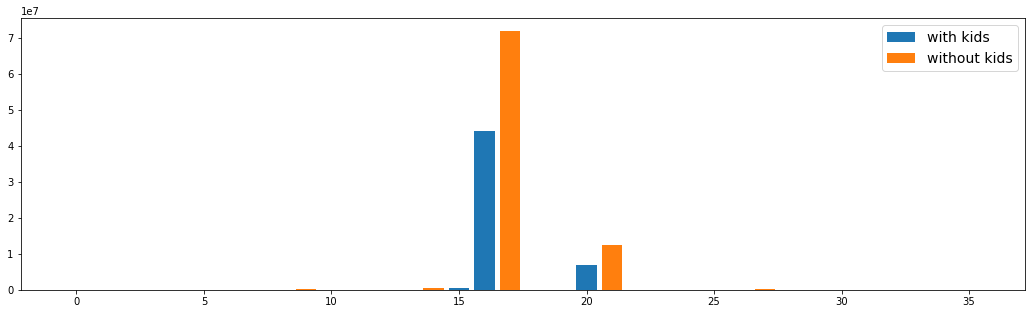

In [84]:
f, ax = plt.subplots(figsize=(18,5))
plt.bar(new_df.department_code, new_df.quantity_with_kids, label = 'with kids')
plt.bar(new_df_2.department_code, new_df_2.quantity_without_kids, label = 'without kids')
ax.legend(fontsize = 14)
plt.show()

### 3. LightFM

У этого алогритма есть множество параметров (item/user_alpha, loss, no_components).  
Проведите эксперименты аналогично дз 3 (подберите гипперпараметры каким удобно способои и постройте графики)  
На выходе необходимо получить pr@5 на валидации (последние 3 недели) > 2%  

У Вас, скорее всего, возникнет проблема со временем обучения. Почему они возникает?    

Попробуйте запустить алгоритм вообще без фичей или используйте только признаки с небольшим числом уникальных категорий. (item_features['commodity_desc'].unique() - 300 уникальных категорий - это очень много)

### *Отбор признаков* * 

Все данные категориальные, при ohe кодировании для товаров признаков становится невероятно много.      
Какие стратегии отбора признаков в классическом ML Вы знаете? Применимы ли они тут?  

Попробйте какие-нибудь стратегии. Удалось ли улучшить качество?

 \* *задание необязательно*
